In [90]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# Part a)

In [135]:
def isfloat(s):
    try:
        float(s)
    except Exception:
        return False
    return True

with open('cluster.txt') as f:
    lines = f.readlines()

raw = []
for l in lines:
    if '#' in l:
        del l
    else:
        d = l.split()
        raw.append(d)

for r, row in enumerate(raw):
    for c, col in enumerate(raw[r]):
        if not isfloat(col):
            if col == 'Head':
                raw[r][c] = 0
            elif col == 'Ear_left':
                raw[r][c] = 1
            else:
                raw[r][c] = 2
        else:
            raw[r][c] = float(col)

data = np.array(raw)

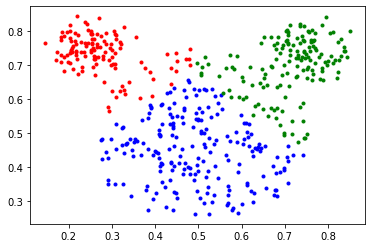

The confusion matrix from my predictions is:
[[211  25  54]
 [  0 100   0]
 [  0   0 100]]


In [136]:
X_data = data[:, :2]
y_data = data[:, 2].flatten()

kmeans = KMeans(n_clusters=3, random_state=3).fit(X_data)
y_hat = kmeans.labels_

head_predict = X_data[y_hat == 0]
Ear_left_predict = X_data[y_hat == 1]
Ear_right_predict = X_data[y_hat == 2]

plt.plot(head_predict[:, 0], head_predict[:, 1], '.', color='b')
plt.plot(Ear_left_predict[:, 0], Ear_left_predict[:, 1], '.', color='r')
plt.plot(Ear_right_predict[:, 0], Ear_right_predict[:, 1], '.', color='g')
plt.show()

cfm_km = confusion_matrix(y_data, y_hat)

print('The confusion matrix from my predictions is:\n' + str(cfm_km))

# Part b)

In [142]:
def _likelihood(dat, w, mu, cov):
    l = 0
    for n in range(dat.shape[0]):
        inner_sum = 0
        for k in range(K):
            inner_sum += w[k]*scipy.stats.multivariate_normal.pdf(dat[n], mu[k], cov[k])
        l += np.log(inner_sum)
    
    return l

def gmm(dat, K, km, tol=1e-10):
    w = np.full((K,), 1/K)
    
    spl = np.array_split(dat, K)
    mu = np.array([np.mean(S, axis=0) for S in spl])
    cov = np.array([np.cov(S.T) for S in spl])
    
    gamma = np.zeros((X_data.shape[0], K))
    one_hot = km.labels_
    for i, _ in enumerate(one_hot):
        gamma[i, _] += 1
    
    prev_l = 0
    l = _likelihood(dat, w, mu, cov)

    i = 1
    first_four = []
    while abs(prev_l-l) >= tol:
        prev_l = l

        if i <= 4:
            first_four.append(gamma)
            i += 1
        
        for n in range(dat.shape[0]):
            for k in range(K):
                gamma[n, k] = w[k]*scipy.stats.multivariate_normal.pdf(dat[n], mu[k], cov[k])

            gamma[n] /= np.sum(gamma[n])

        for k in range(K):
            w[k] = np.sum(gamma[:, k])/dat.shape[0]

            for n in range(dat.shape[0]):
                mu[k] += gamma[n, k]*dat[n]

            mu[k] /= np.sum(gamma[:, k])
            
            for n in range(dat.shape[0]):
                cov[k] += gamma[n, k]*np.dot((dat[n]-mu[k])[:, np.newaxis], (dat[n]-mu[k])[:, np.newaxis].T)
                
            cov[k] /= np.sum(gamma[:, k])

        l = _likelihood(dat, w, mu, cov)

    return gamma, first_four

The confusion matrix from my predictions is:
[[290   0   0]
 [  1  99   0]
 [  0   0 100]]


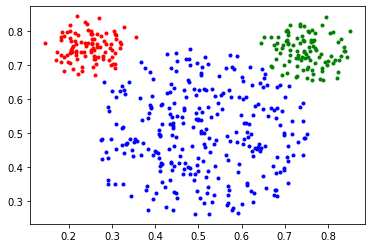

In [143]:
K = 3
kmeans = KMeans(n_clusters=K, random_state=3).fit(X_data)
gamma, first_four = gmm(X_data, K, kmeans)
y_pred = np.array([np.argmax(g) for g in gamma])
cfm_gmm = confusion_matrix(y_data, y_pred)

print('The confusion matrix from my predictions is:\n' + str(cfm_gmm))

head_pred = X_data[y_pred == 0]
Ear_left_pred = X_data[y_pred == 1]
Ear_right_pred = X_data[y_pred == 2]

plt.plot(head_pred[:, 0], head_pred[:, 1], '.', color='b')
plt.plot(Ear_left_pred[:, 0], Ear_left_pred[:, 1], '.', color='r')
plt.plot(Ear_right_pred[:, 0], Ear_right_pred[:, 1], '.', color='g')
plt.show()

### The plots seem to differ mainly at the borders between the colored clusters. For the kmeans algorithm, there was a portion of the top of the blue cluster that was mainly split between the colors red and green whereas with a gaussian mixture model, the three clusters seem to be more clearly separated with the blue cluster containing the top half which was not the case with kmeans, and the red and green clusters have smaller regions. This is also corroborated with the confusion matrices for each of the algorithms respectively. For the first one, the confusion matrix showed incorrectly classified points for the red and green cluster whereas for GMM, the correctly classified points far outweighed the incorrectly classified points with only one being incorrectly classified. So, it is clear from this analysis that GMM performs better than kMeans.

Below are the class assignments from my predictions, plotted as in both parts a) and b), from the first four iterations: 


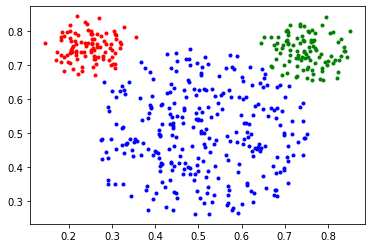

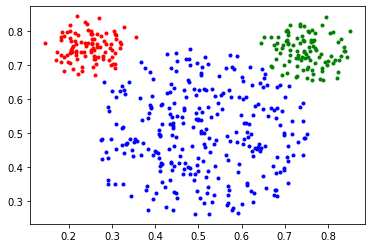

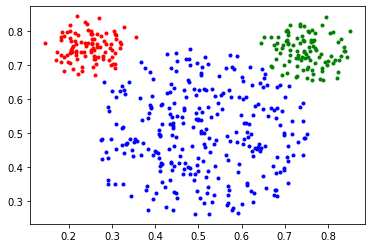

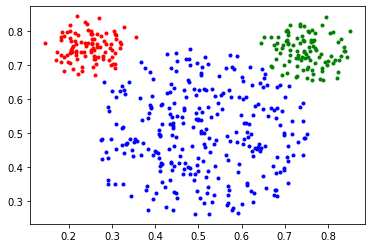

In [147]:
y_pred_first_four = [np.array([np.argmax(g) for g in ffg]) for ffg in first_four]

for y_pred_ff in y_pred_first_four:
    head_pred = X_data[y_pred_ff == 0]
    Ear_left_pred = X_data[y_pred_ff == 1]
    Ear_right_pred = X_data[y_pred_ff == 2]

    plt.figure()
    plt.plot(head_pred[:, 0], head_pred[:, 1], '.', color='b')
    plt.plot(Ear_left_pred[:, 0], Ear_left_pred[:, 1], '.', color='r')
    plt.plot(Ear_right_pred[:, 0], Ear_right_pred[:, 1], '.', color='g')

print("Below are the class assignments from my predictions, plotted as in both parts a) and b), from the first four iterations: ")
plt.show()